### **Q1. Model the game of Snakes and Ladders (single-player game) as a Markov Process. Write out it’s state space and structure of transition probabilities.**

State space $S$ are a set of integer k, where $1 \leq k \leq N_{stop}$ and k is not the start of a ladder of snake. It is due to the start of ladder or snake will never be the start or end of a step.

Here we define two dictionaries ladder and snake in the data class SL_rules, where (key,value) pair are starts and ends of ladder or snake.

According to the discussion in https://piazza.com/class/kjgrmumjhtc3br?cid=36, when we get a 6 in dice roll and win an extra roll, this roll is regarded as a new step.  Transition probability can be calculated given the rules. From any start point $k \in S$, we roll a dice. For result in [1,6], we have the probability of $k + roll result$ of $dic[k+roll result]$ if there is a ladder or snake here is $1/6$.
In the cases when $k+roll result > N_{stop}$, we apply $1/6$ probability to positions in [k,N_{stop}-1] and apply $(7-(N_{stop}-k))/6$ to the stop position.





### **Q2. Create a transition map**
Define SL_state to record the position of the player. SL_Rules to record the stop position and positions of snakes and ladders

In [11]:
from rl import markov_process, distribution
from typing import (Dict, Iterable, Generic, Sequence, Tuple,
                    Mapping, Optional, TypeVar)
from dataclasses import dataclass
from rl.distribution import Categorical
import matplotlib.pyplot as plt

@dataclass(frozen=True)
class SL_State:
    position: int

@dataclass(frozen=True)
class SL_Rules:
    stopstate: int
    snake: Dict[int,int]
    ladder: Dict[int,int]

class SL_MDP(markov_process.FiniteMarkovProcess[SL_State]):

    def __init__(self, sl_rule: SL_Rules):
        self.sl_rule = sl_rule
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> markov_process.Transition[SL_State]:
        d: Dict[SL_State, Categorical[SL_State]] = {}
        n = self.sl_rule.stopstate
        d[SL_State(n)] = None
        for k in range(n):
            if (k not in self.sl_rule.ladder.keys()) and (k not in self.sl_rule.snake.keys()):
                temp_dict: Dict[SL_State,float] = {}
                for roll_result in range(1,7):
                    if k + roll_result in self.sl_rule.snake.keys():
                        temp_dict[SL_State(self.sl_rule.snake[k+roll_result])] = 1/6
                    elif k + roll_result in self.sl_rule.ladder.keys():
                        temp_dict[SL_State(self.sl_rule.ladder[k+roll_result])] = 1/6
                    elif k + roll_result >= n:
                        temp_dict[SL_State(n)] = (7-roll_result)/6
                    else:
                        temp_dict[SL_State(k+roll_result)] = 1/6

                d[SL_State(k)] = Categorical(temp_dict)

        return d

Show the MDP for a simple case with stop position = 8.

In [12]:
sl_rules = SL_Rules(stopstate=10, snake={5:3},
                    ladder = {2:4})
mdp = SL_MDP(sl_rules)
mdp

SL_State(position=10) is a Terminal State
From State SL_State(position=0):
  To State SL_State(position=1) with Probability 0.250
  To State SL_State(position=4) with Probability 0.250
  To State SL_State(position=3) with Probability 0.250
  To State SL_State(position=6) with Probability 0.250
From State SL_State(position=1):
  To State SL_State(position=4) with Probability 0.250
  To State SL_State(position=3) with Probability 0.250
  To State SL_State(position=6) with Probability 0.250
  To State SL_State(position=7) with Probability 0.250
From State SL_State(position=3):
  To State SL_State(position=4) with Probability 0.167
  To State SL_State(position=3) with Probability 0.167
  To State SL_State(position=6) with Probability 0.167
  To State SL_State(position=7) with Probability 0.167
  To State SL_State(position=8) with Probability 0.167
  To State SL_State(position=9) with Probability 0.167
From State SL_State(position=4):
  To State SL_State(position=3) with Probability 0.167
 

Calculate an example from https://piazza.com/class/kjgrmumjhtc3br?cid=17.

In [13]:
sl_rules = SL_Rules(stopstate=100, snake ={38:1,31:6,49:8,53:17,65:14,76:37,70:34,94:42,88:50,98:54,82:63},
                    ladder = {3:39,7:48,12:51,20:41,25:57,28:35,45:74,60:85,67:90,69:92,77:83})
mdp = SL_MDP(sl_rules)

Show three traces

<class 'rl.distribution.Categorical'>


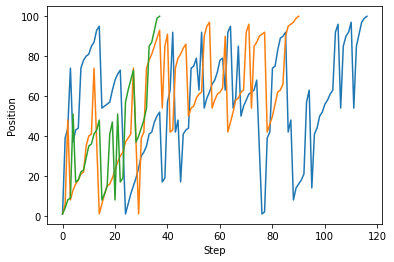

In [14]:
start_distr = Categorical({SL_State(1): 1})
print(type(start_distr))
plt.figure()
for i, trace in enumerate(mdp.traces(start_distr)):
    traj = []
    for _,x in enumerate(trace):
        traj += [x.position]
    plt.plot(traj)
    if i > 1:
        break
plt.xlabel('Step')
plt.ylabel('Position')
plt.show()

Calculate the distribution of time steps to finish the game

<class 'rl.distribution.Categorical'>


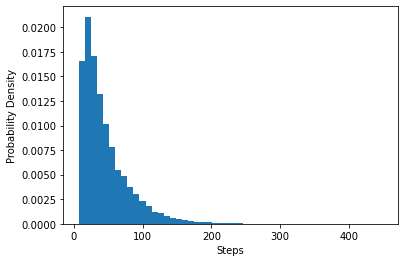

In [20]:
start_distr = Categorical({SL_State(1): 1})
print(type(start_distr))
timesteps =[]
for i,trace in enumerate(mdp.traces(start_distr)):
    timesteps += [sum(1 for _ in trace)]
    if i > 50000:
        break

plt.hist(timesteps,bins = 50,density=True)
plt.xlabel('Steps')
plt.ylabel('Probability Density')
plt.show()

### **Q3. Extend the Snakes and Ladders FiniteMarkovProcess to an appropriate FiniteMarkovRewardProcess instance to determine the expected number of dice rolls to finish the game.**

For each time step, we apply reward $R_t = 1$ with probability 1 if $S_{t} \leq N_{stop}$. Otherwise $R_t = 0$. Using $\gamma = 1$ in the return $G_t$, we have that
$V(s) = expected \ number \ of  \ steps \  from \ state \ s$. Therefore, calculating $V(1)$ from Bellman Equation will give what we need.